# Running some tests

### Doc - Datetime functions

In [67]:
if True:
    import datetime
    # Description of all datetime operations
    d = datetime.datetime.now()
    print(d.isoweekday())
    print(d)
    # Jour dans le mois
    print(d.day)
    # Numéro du mois
    print(d.month)
    # Année
    print(d.year)
    # Jour travaillé (0/1)
    print(d.isoweekday())
    # Heure
    print(d.hour)
    # Minutes
    print(d.minute)
    # Secondes
    print(d.second)

2
2017-01-03 13:52:25.952278
3
1
2017
2
13
52
25


# Feature Extraction

## Feature functions

In [55]:
# Few functions to add features to the dataframe.


def is_working_day(d):
    return d.isoweekday()<6

def trimester(d):
    return (d.month-1)//3

def is_day_shift(d):
    min_hour = {
        'hour':7,
        'minute':30
    }
    max_hour = {
        'hour':23,
        'minute':30
    }
    hour_day = d.hour*60+d.minute
    return (hour_day > min_hour['hour']*60+min_hour['minute']) & (hour_day < max_hour['hour']*60+max_hour['minute'])

def evolution_over_years(d):
    min_date = {
        "year": 2011,
        "month": 1,
        "day": 1
    }
    date_trimester = trimester(d)
    year = d.year
    return (year-min_date['year'])*4+date_trimester

def previous_days(df, nb_days, year, month, day):
    difference_days = day-nb_days
    if (difference_days < 0):
        if (month==0):
            if (year==2011):
                df_output = df[(df.year == year) & (df.month == 0) & (df.day < day)]
            else:
                df_output = df[((df.year == year) & (df.month == 0) & (df.day < day)) | ((df.year == year-1) & (df.month >= 11) & (df.day > 31-abs(difference_days)))]
        else:
            df_output = df[(df.year == year) & (((df.month == month) & (df.day <= day)) | ((df.month == month-1) & (df.day >= 31-abs(difference_days))))]          
    else:
        df_output = df[(df.year==year) & (df.month == month) & (df.day<=day) & (df.day > day-nb_days)]
        
    return df_output

## Libraries

In [46]:
# All library imports
import math
import pandas as pd
import numpy as np
import error_functions as ef
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

In [47]:
# Map to convert ass_assignments to integer values
assignments = ['CAT', 'CMS', 'Crises', 'Domicile',
       'Evenements', 'Gestion', 'Gestion - Accueil Telephonique',
       'Gestion Amex', 'Gestion Assurances', 'Gestion Clients', 'Gestion DZ',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon', 'Manager',
       'Mécanicien', 'Médical', 'Nuit', 'Prestataires', 'RENAULT', 'RTC',
       'Regulation Medicale', 'SAP', 'Services', 'Tech. Axa', 'Tech. Inter',
       'Tech. Total', 'Téléphonie']

map_assignment = {}
for i in range(len(assignments)):
    map_assignment[assignments[i]]=i
    
map_assignment_inverse = {}
for i in range(len(assignments)):
    map_assignment_inverse[i] = assignments[i]

In [48]:
print("Importing train values...")
calls = pd.read_csv('data/train.csv', delimiter=';', nrows=1000000)
print("Reading train file ok.")
y = calls['CSPL_CALLS']
print("Extracting results ok.")
print("Importing submission values...")
submission = pd.read_csv('data/submission.txt', sep="\t")
print("Reading submission file ok.")
submission = submission.drop('prediction', axis=1)
print("Dropping prediction from submission ok.")

Importing train values...
Reading train file ok.
Extracting results ok.
Importing submission values...
Reading submission file ok.
Dropping prediction from submission ok.


In [49]:
calls['DATE'] = pd.to_datetime(calls['DATE'],infer_datetime_format=True)
print("Train date to timetable ok.")
submission['DATE'] = pd.to_datetime(submission['DATE'],infer_datetime_format=True)
print("Submission date to timetable ok.")

Train date to timetable ok.
Submission date to timetable ok.


In [77]:
calls = calls[["DATE", "ASS_ASSIGNMENT"]]
print("Extraction of columns date and ass_assignment ok.")
print("")
print("Adding new features to train...")
calls['year'] = [dd.year for dd in calls['DATE']]
calls['month'] = [dd.month for dd in calls['DATE']]
calls['day'] = [dd.day for dd in calls['DATE']]
print("Year, month, day ok.")
calls['hour'] = [dd.hour for dd in calls['DATE']]
calls['minute'] = [dd.minute for dd in calls['DATE']]
#calls['second'] = [dd.second for dd in calls['DATE']]
print("Hour, minute ok.")
calls['working'] = [is_working_day(dd) for dd in calls['DATE']]
print("Working day ok.")
calls['shift'] = [is_day_shift(dd) for dd in calls['DATE']]
print("Shift ok.")
calls['trimester'] = [trimester(dd) for dd in calls['DATE']]
print("Trimester ok.")
calls['evolution'] = [evolution_over_years(dd) for dd in calls['DATE']]
print("Evolution ok.")
calls['assignment'] = calls['ASS_ASSIGNMENT'].map(map_assignment)
print("Creating dummies ok.")
calls['day_number'] = [dd.isoweekday() for dd in calls['DATE']]
submission['day_number'] = [dd.isoweekday() for dd in submission['DATE']]
print("")
print("Adding new features to submission...")
submission['year'] = [dd.year for dd in submission['DATE']]
submission['month'] = [dd.month for dd in submission['DATE']]
submission['day'] = [dd.day for dd in submission['DATE']]
print("Year, month, day ok.")
submission['hour'] = [dd.hour for dd in submission['DATE']]
submission['minute'] = [dd.minute for dd in submission['DATE']]
#submission['second'] = [dd.second for dd in submission['DATE']]
print("Hour, minute ok.")
submission['working'] = [is_working_day(dd) for dd in submission['DATE']]
print("Working day ok.")
submission['shift'] = [is_day_shift(dd) for dd in submission['DATE']]
print("Shift ok.")
submission['trimester'] = [trimester(dd) for dd in submission['DATE']]
print("Trimester ok.")
submission['evolution'] = [evolution_over_years(dd) for dd in submission['DATE']]
print("Evolution ok.")
submission['assignment'] = submission['ASS_ASSIGNMENT'].map(map_assignment)
print("Creating dummies ok.")
save_date = submission['DATE']
print("Saving date column ok.")
save_ass_assignment = submission['ASS_ASSIGNMENT']
print("Saving ass_assignment ok.")


KeyError: "['DATE' 'ASS_ASSIGNMENT'] not in index"

In [74]:
calls = calls.drop(['DATE','ASS_ASSIGNMENT'], axis=1)
print("Dropping string columns calls ok.")
submission = submission.drop(['DATE','ASS_ASSIGNMENT'], axis=1)
print("Dropping string columns submission ok.")

Dropping string columns calls ok.
Dropping string columns submission ok.


## Test sur les features

In [68]:
test_calls = calls.copy()
val_calls = y.copy()
test_calls['value'] = val_calls
test_submissions = submission.copy()

In [70]:
test_calls_cat = test_calls[test_calls['ASS_ASSIGNMENT']=="CAT"]
test_calls_cat_day = test_calls_cat[(test_calls_cat['hour']>8) & (test_calls_cat['hour']<20)]
first_year = test_calls_cat[test_calls_cat['year'] == 2011]
first_month = first_year[first_year['month']==1]
first_week = first_month[first_month['day']<30]
x = 24*np.array(first_week['day']) + np.array(first_week['hour'])
first_week['x'] = x

C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
graph = sns.swarmplot(x='day_number', y='value', data=first_week)

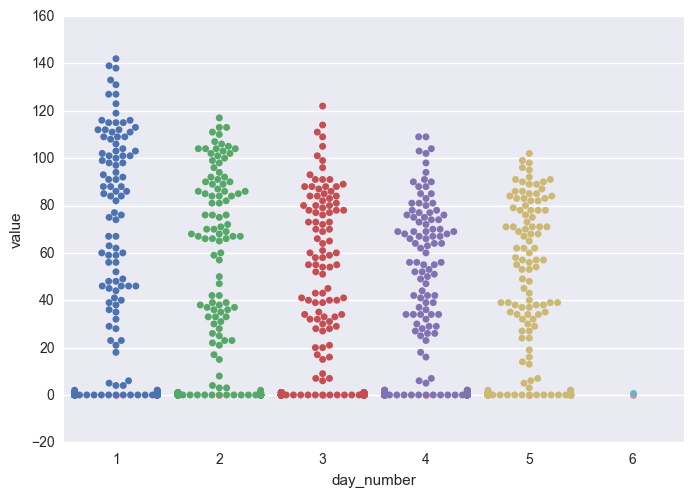

In [73]:
sns.plt.show()

# Implementing regressor

## Basic cross-validation with one regressor

In [7]:
if False:
    print("------------------------")
    print("--- CROSS VALIDATION ---")
    print("")
    print("Creating regressor...")
    X_train, X_test, y_train, y_test = train_test_split(calls, y, test_size=82909)
    print("Splitting train from test ok.")
    S=Ridge()
    print("Instanciating regressor ok.")
    S.fit(X_train, y_train)
    print("Training phase ok.")
    y2=S.predict(X_test)
    print("Prediction ok.")
    y_test = np.array(y_test)
    print("Pandas series to numpy array ok.")
    loss = ef.linex_loss(y2, y_test)
    print("Compute of loss ok : ", loss)

## Multiple regressors over ASS_ASSIGNMENT category

Applying also a differenciation of regressors for high values and low values

In [75]:
map_regressor = {}
big_values_regressor = {}
huge_values_regressor = {}
number_values = {}

for i in range(len(assignments)):
    number_values[i] = {
        "big":0,
        "huge":0
    }
    map_regressor[i] = Ridge()
    big_values_regressor[i] = Ridge()
    huge_values_regressor[i] = Ridge()
    
print("--- TRAINING ---")
X_train, X_test, y_train, y_test = train_test_split(calls, y, test_size=1)
X_train_full = X_train
X_train_full['pred'] = y_train
X_test_full = X_test
X_test_full['pred'] = y_test
for i in range(len(assignments)):
    el_x = X_train_full[X_train_full['assignment']==i]
    big_x = el_x[el_x['pred'] > 19]
    huge_x = el_x[el_x['pred'] > 49]
    big_elements = big_x.shape[0]
    huge_elements = huge_x.shape[0]
    number_values[i] = {
        "big":big_elements,
        "huge":huge_elements
    }
    big_y = big_x['pred']
    big_x = big_x.drop('pred', axis=1)
    el_y = el_x['pred']
    el_x = el_x.drop("pred", axis=1)
    map_regressor[i].fit(el_x, el_y)
    if big_elements>0:
        big_values_regressor[i].fit(big_x, big_y)
    
    huge_y = huge_x['pred']
    huge_x = huge_x.drop('pred', axis = 1)
    if huge_elements>0:
        huge_values_regressor[i].fit(huge_x, huge_y)

--- TRAINING ---


C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [76]:
error = 0
size = 0

min_values_of_fitting = 20

for i in range(len(assignments)):
    el_x = X_test_full[X_test_full['assignment']==i]
    size += len(el_x)
    el_y = el_x['pred']
    el_x = el_x.drop('pred', axis=1)
    y2 = map_regressor[i].predict(el_x)
    el_y = np.array(el_y)
    y2 = np.round(np.array(y2))
    is_big_regressor_fitted = number_values[i]['big']>min_values_of_fitting
    is_huge_regressor_fitted = number_values[i]['huge']>min_values_of_fitting
    for i, pred in np.ndenumerate(y2):
        if (pred > 19) and is_big_regressor_fitted :
            tmp = el_x.iloc[i]
            assign = tmp.assignment
            y2[i] = big_values_regressor[assign].predict(tmp)
            y2[i] = np.round(y2[i])
    
        if (y2[i] > 49) and is_huge_regressor_fitted:
            tmp = el_x.iloc[i]
            assign = tmp.assignment
            y2[i] = huge_values_regressor[assign].predict(tmp)
            y2[i] = np.round(y2[i])
    
    error_tmp = ef.linex_loss(np.array(y2), np.array(el_y))
    imax = np.argmax(np.abs(np.array(y2)-np.array(el_y)))
    error += error_tmp
    
print("size ", size)
print("loss ", error)

ValueError: Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.

## Trying it on submission.txt

In [8]:
submission_copy = submission.copy()
final_result = submission.copy()

min_values_of_fitting = 10

In [ ]:
def predict_line(line_to_predict, map_basic, map_big, map_huge, number_fitting, min_fitting_value):
    assign = line_to_predict.assignment
    prediction = map_basic[assign].predict(line_to_predict)
    prediction = np.round(prediction)
    
    is_big_regressor_fitted = number_fitting[assign]['big']>min_fitting_value
    is_huge_regressor_fitted = number_fitting[assign]['huge']>min_fitting_value
    
    if (prediction > 19) and is_big_regressor_fitted:
        prediction = np.round(map_big[assign].predict(line_to_predict))
    if (prediction > 49) and is_huge_regressor_fitted:
        prediction = np.round(map_huge[assign].predict(line_to_predict))

    return prediction

for index, row in final_result.iterrows():
    row['pred'] = predict_line(row, map_regressor, big_values_regressor, huge_values_regressor, number_values, min_values_of_fitting)
    if i % 50 == 0:
        print(i)    

C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single

## Multiple regressors over SHIFT (Day/Night) category

In [61]:
if False:
    print("------------------------")
    print("--- CROSS VALIDATION ---")
    print("")
    separate_calls = calls
    separate_calls['call'] = y
    day_calls = separate_calls[separate_calls['shift']==1]
    y_day = day_calls['call']
    day_calls.drop('call', axis=1)
    night_calls = separate_calls[separate_calls['shift']==0]
    y_night = night_calls['call']
    night_calls.drop('call', axis=1)

    print("Creating regressor...")

    X_day_train, X_day_test, y_day_train, y_day_test = train_test_split(day_calls, y_day, test_size=56590)
    X_night_train, X_night_test, y_night_train, y_night_test = train_test_split(night_calls, y_night, test_size=26319)
    print("Splitting train from test ok.")

    day_regressor = Ridge()
    night_regressor = Ridge()
    print("Instanciating regressors (day/night) ok.")

    day_regressor.fit(X_day_train, y_day_train)
    night_regressor.fit(X_night_train, y_night_train)
    print("Training phase ok.")

    y2_night = night_regressor.predict(X_night_test)
    X_night_test['pred']=y2_night
    y2_day = day_regressor.predict(X_day_test)
    X_day_test['pred']=y2_day
    new_calls = pd.concat([X_night_test, X_day_test], axis=0)
    y2 = new_calls['pred']
    print("Prediction ok.")

    y_test = np.array(y_test)
    y2 = np.array(y2)
    print("Pandas series to numpy array ok.")
    loss = ef.linex_loss(y2, y_test)
    print("Compute of loss ok : ", loss)

------------------------
--- CROSS VALIDATION ---

Creating regressor...
Splitting train from test ok.
Instanciating regressors (day/night) ok.
Training phase ok.


C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Prediction ok.
Pandas series to numpy array ok.
Compute of loss ok :  177141729136.0


## Regression over submission values

In [ ]:
print("------------------")
print("--- SUBMISSION ---")
print("")
S=Ridge()
print("Instanciating regressor ok.")
S.fit(calls, y)
print("Training phase ok.")
y2=S.predict(submission)
print("Prediction ok.")
for i, el in np.ndenumerate(y2):
    if el < 0:
        y2[i] = 0
    else:
        y2[i] = int(math.floor(y2[i]))
print("Taking floor value of prediction")
submission['DATE'] = save_date
submission['ASS_ASSIGNMENT'] = save_ass_assignment
submission['prediction'] = y2
print("Adding date, ass_assignment, prediction to dataframe ok.")
submission = submission[['DATE', 'ASS_ASSIGNMENT', 'prediction']]
print("Dropping all other columns ok.")
submission.to_csv("submission_test.txt", sep="\t", index=False)
print("Writing to file ok.")

## Regressor over time lapse mixed with category regressor

In [8]:
X_train, X_test, y_train, y_test = train_test_split(calls, y, test_size=82909)

In [9]:
X_test.sort_values(['year', 'month', 'day', 'hour', 'minute'], ascending = True);

In [10]:
nb_previous_days = 2
clf = Ridge()
count = 0
for index, row in X_test.iterrows():
    year = row['year']
    month = row['month']
    day = row['day']
    df_train = previous_days(X_train, nb_previous_days, year, month, day)
    

In [15]:
map_regressor = {}
for i in range(len(assignments)):
    map_regressor[i] = Ridge()

count_fitting = {}
for i in range(len(assignments)):
    count_fitting[i] = 0

In [16]:
X_train_full = X_train
X_train_full['pred'] = y_train
X_test_full = X_test
X_test_full['pred'] = y_test
for i in range(len(assignments)):
    el_x = X_train_full[X_train_full['assignment']==i]
    for index, row in el_x.iterrows():
        pred_val = row['pred']
        row.drop('pred')
        year = row['year']
        month = row['month']
        day = row['day']
        df_train = previous_days(row, nb_previous_days, year, month, day)
        count_fitting[i] += 1
        map_regressor[i].fit(df_train, pred_val)
        if (count_fitting[i] > 600):
            print(assignments[i], " fitted.")
            break

C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Raphael\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TypeError: Singleton array array(0) cannot be considered a valid collection.

In [6]:
toto = 2.8
int(toto)

2

In [17]:
toto = [2, 3]
titi = [1, 2]

for i, (x1, x2) in np.ndenumerate(zip(toto, titi)):
    print(i, x1, x2)

() (2, 1) (3, 2)


In [74]:
A = (1,2)
A[1]

2

In [80]:
for i in range(len(assignments)):
    print(number_values[i]['big'], number_values[i]['huge'])

94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
94673 24904
